## Code walkthrough

In [2]:
import importlib
import os
import time
import base64
from dotenv import load_dotenv
import cv2
from openai import AsyncOpenAI
from video_labeling.utils import extract_frames_from_video
from IPython.display import Image

In [3]:
import video_labeling
importlib.reload(video_labeling)

<module 'video_labeling' from '/Users/niccolofusai/Documents/pi/video_labeling/__init__.py'>

In [61]:
from video_labeling.main import identify_moved_objects, label_actions_in_episode, label_episode_frame_ranges, run_checks, adjusting_frames_in_episode

In [81]:
def render_video(start_frame, end_frame, fps, render_frame=-1): 
    frames = extract_frames_from_video(VIDEO_PATH, start_frame, end_frame, fps=fps)
    
    display_handle = display(None, display_id=True)
    for idx, img in enumerate(frames):  
        if idx==render_frame: 
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)
            break
        else:    
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)

#### Load in your env variables

In [6]:
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
VIDEO_PATH = os.getenv('VIDEO_PATH')
FRAMES_SEGMENT_SIZE = int(os.getenv('FRAMES_SEGMENT_SIZE'))

print(VIDEO_PATH)
print(FRAMES_SEGMENT_SIZE)

/Users/niccolofusai/Documents/pi/data/input/pi_video_test.mp4
300


In [7]:
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

## Step 0: Get frame ranges

In [8]:
video = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video.release()
video_chunks = [
    (max(0, i - FRAMES_SEGMENT_SIZE), min(total_frames, i))
    for i in range(
        FRAMES_SEGMENT_SIZE, total_frames + FRAMES_SEGMENT_SIZE, FRAMES_SEGMENT_SIZE
    )
]

In [9]:
print(f"total frames are: {total_frames}")
print(f"video chunks are: {video_chunks}")

total frames are: 1116
video chunks are: [(0, 300), (300, 600), (600, 900), (900, 1116)]


## Step 1: Identify which objects have moved in the chunks

In [10]:
moved_objects = await identify_moved_objects(client, VIDEO_PATH, video_chunks)

In [11]:
moved_objects

[{'moved_objects': ['Glass Bowl']},
 {'moved_objects': ['Plastic Bowl', 'Orange Plate']},
 {'moved_objects': ['Metal Spoon', 'Aluminum Container']},
 {'moved_objects': ['Black Chopstick']}]

Great now we see which object has moved for each video chunk above.  
The next step is to determine the action that took place in each chunk

## Step 2: Identify the actions that took place in those chunks

In [12]:
labeled_actions = await label_actions_in_episode(client, VIDEO_PATH, moved_objects, video_chunks)


Put Aluminum Container into Blue Trash Bin
810.0 900.0


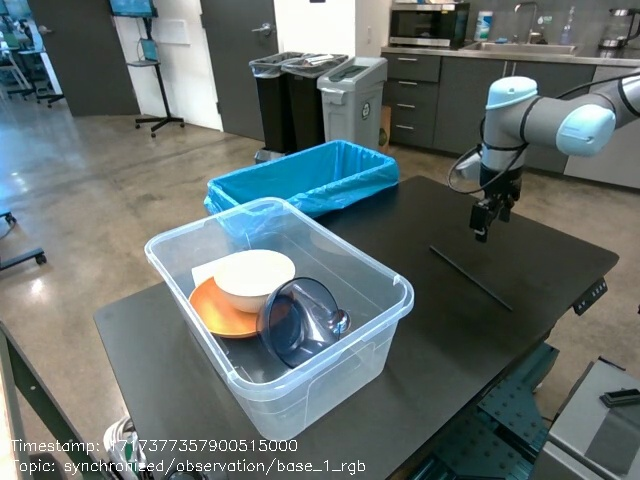

In [13]:
idx = 9
labeled_actions[idx]
test = labeled_actions[idx]
print(test['action'])
print(test['start_frame'], test['end_frame'])
render_video(test['start_frame'], test['end_frame'], 10 )

Great here we see the actions labeled correctly. We fed in the objects that had moved to the model and it determined correctly which actions had taken place.  
You also see the model outputted the image range. This is a second order priority for the model, and while they are "roughly" accurate, a lot of work needs to be done in identifying the correct ranges.

## Step 3: Identify correct start and end frame for the action in the episode

In [14]:
labeled_frames = await label_episode_frame_ranges(labeled_actions)


In [55]:
idx = 6
labeled_frames[idx]
test = labeled_frames[idx]

Pick up Metal Spoon


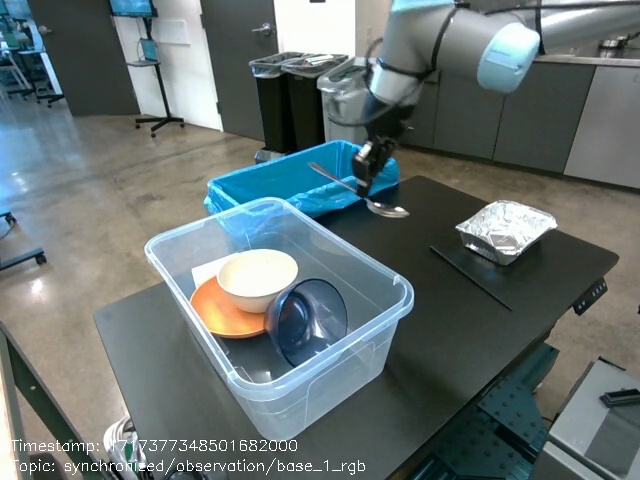

In [56]:
print(test['action'])
render_video(test['start_frame'], test['end_frame'], 10 )

So you can see, it did pretty well. Now lets run our checks

### Step 4: Running Checks

In [39]:
checks_feedback = await run_checks(labeled_frames, fps=5)

In [59]:
checks_feedback[8]

{'action': 'Pick up Aluminum Container',
 'start_image': 1,
 'end_image': 8,
 'start_frame': 690.0,
 'end_frame': 810.0,
 'fps': 2,
 'action_type': 'pick',
 'object': 'Aluminum Container',
 'start_answer': 'In the first image, the Aluminum Container is on the table, and there is some space between the gripper and the Aluminum Container. The robot has not yet grasped the object, and it is not holding any other object.\n\nBased on the criteria provided, the first image strictly satisfies the criteria for the START image of the action "Pick up Aluminum Container."\n\n```json\n{\n"answer":"perfect"\n}\n```',
 'end_answer': 'Upon analyzing the final image, the following observations are made:\n\n- The Aluminum Container is no longer on the table.\n- The robot gripper is holding the Aluminum Container, as indicated by the visible grasping action.\n\nThese observations confirm that the Aluminum Container has been successfully picked up by the robot, meeting the criteria for the END image of t

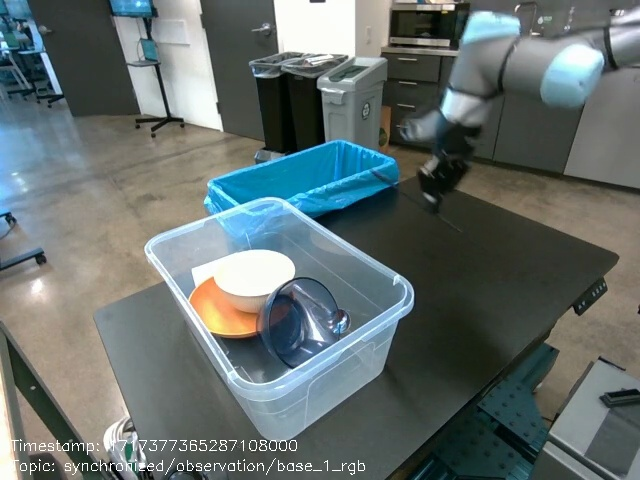

In [68]:
idx = 10
test = checks_feedback[idx]
render_video(test['start_frame'], test['end_frame'], test['fps'] )

### Step 5: For actions that weren't perfect, we can take action to correct them

In [69]:
final_results = await adjusting_frames_in_episode(checks_feedback)

Pick up Aluminum Container


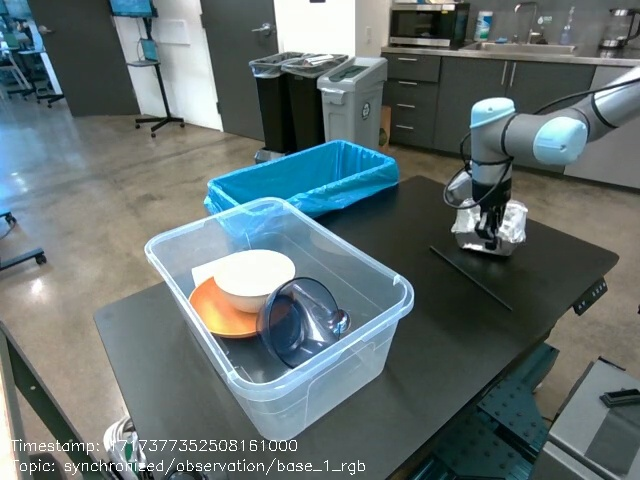

In [76]:
idx = 8
test = final_results[idx]
print(test['action'])
render_video(test['start_frame'], test['end_frame'], test['fps'] )

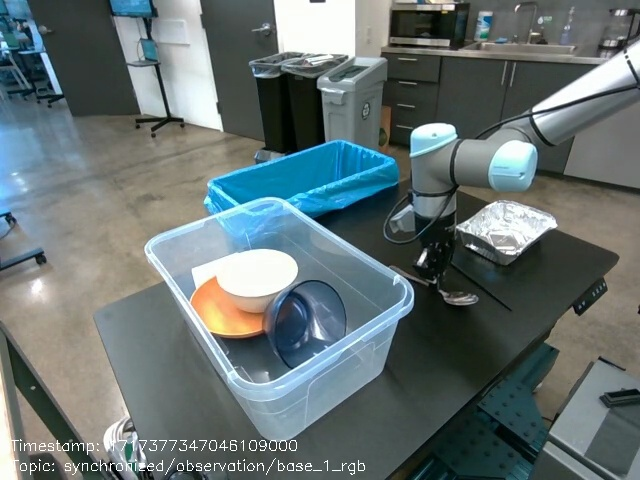

In [83]:
render_video(test['start_frame'], test['end_frame'], test['fps'], render_frame=0 )